In [23]:
from time import time
import torch
import numpy as np
import torch.nn.functional as F
from typing import List
from collections import OrderedDict
from torch import nn
from torch import asin
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.dataloader import default_collate
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import math

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
from layers import LinearArcsine, RandomFeatureMap, ArcsinNN, RepresentArcsineNN, ApproxArcsineNN

In [4]:
indicators = [lambda x: (x>0).float(), lambda x: ((torch.tanh(x) + 1)/2).float(), lambda x: (torch.atan(x) * 2 / np.pi + 1).float(), lambda x: torch.sigmoid(x).float(), lambda x: torch.sigmoid(10 * x).float(), lambda x: torch.sigmoid(20 * x).float()]
indicator_names = ['indicator', 'tanh', 'arctan', 'sigmoid(x)', 'sigmoid(10x)', 'sigmoid(20x)']

In [5]:
sigmoid_indicator = lambda x: torch.sigmoid(x).float()

### Approximation quality

In [32]:
"""
Error of approximation v.s. output dimension
input dim = output dim
"""
N = 100
dims = np.arange(250,10100,250)
error = [{}]*len(indicators)
rng = torch.Generator(device=device)
rng.manual_seed(20220815)
for i, indicator in enumerate(indicators):
    for d in dims:
        """
        Generate random vectors
        """
        X = F.normalize(torch.randn(size=(N,d), generator=rng, device = device), dim=1)
        Y = F.normalize(torch.randn(size=(N,d), generator=rng, device = device), dim=1)
        M = torch.asin(torch.matmul(X, Y.T))
        
        f = RandomFeatureMap(in_features=d, device=device, indicator=indicator).float()
        error[i][d] = torch.norm(M - torch.matmul(f(X), f(Y).T) / (2 * d / np.pi))/(N**2)

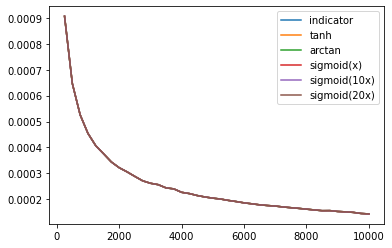

In [34]:
for i, indicator in enumerate(indicators):
    plt.plot(dims, [error[i][d].cpu().float() for d in dims])
plt.legend(indicator_names)

In [36]:
"""
Error of approximation v.s. output dimension
input dim fixed
"""
N = 1000
D = 250
dims = np.arange(250,10100,250)
error_2 = [{}]*len(indicators)
rng = torch.Generator(device=device)
rng.manual_seed(20220815)
"""
Generate random vectors
"""
X = F.normalize(torch.randn(size=(N,D), generator=rng, device = device), dim=1)
Y = F.normalize(torch.randn(size=(N,D), generator=rng, device = device), dim=1)
M = torch.asin(torch.matmul(X, Y.T))

for i, indicator in enumerate(indicators):
    for d in dims:
        err = 0
        for t in range(5):
            f = RandomFeatureMap(in_features=D, out_features=d, device=device).float()
            err += torch.norm(M - torch.matmul(f(X), f(Y).T) / (2 * d/ np.pi) )/(N**2)
        error_2[i][d] = err/5

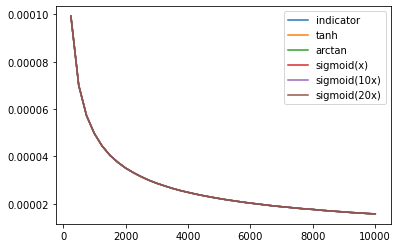

In [37]:
for i, indicator in enumerate(indicators):
    plt.plot(dims, [error_2[i][d].cpu().float() for d in dims])
plt.legend(indicator_names)

### Prepare data

In [6]:
"""
Download data from MNIST
"""
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

learning_rate = 5*1e-3
batch_size = 64
epochs = 20
loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(training_data,batch_size=batch_size,collate_fn=lambda x:tuple(x_.to(device) for x_ in default_collate(x)))
test_loader = DataLoader(test_data,batch_size=batch_size,collate_fn=lambda x:tuple(x_.to(device) for x_ in default_collate(x)))

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_agg = []
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float())
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            loss_agg.append(loss)
    return loss_agg

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n accuracy_2: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

### Logistic regression baseline

In [11]:
"""
Baseline: naive logistic regression
"""
acc_logistic, loss_logistic = [], []
for i in range(5):
    logistic_model = nn.Sequential(nn.Flatten(), 
                                nn.Linear(in_features = 784, out_features = 10).to(device),
                                )
    optimizer = torch.optim.Adam(params=logistic_model.parameters(), lr = learning_rate)
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, logistic_model, loss_fn, optimizer)
    acc, loss = test_loop(test_loader, logistic_model, loss_fn)
    acc_logistic.append(acc)
    loss_logistic.append(loss)

Epoch 1
-------------------------------
loss: 2.357607  [    0/60000]
loss: 0.643367  [ 6400/60000]
loss: 0.419335  [12800/60000]
loss: 0.652542  [19200/60000]
loss: 0.547970  [25600/60000]
loss: 0.508522  [32000/60000]
loss: 0.497393  [38400/60000]
loss: 0.621531  [44800/60000]
loss: 0.634490  [51200/60000]
loss: 0.498754  [57600/60000]
Epoch 2
-------------------------------
loss: 0.409141  [    0/60000]
loss: 0.412343  [ 6400/60000]
loss: 0.333522  [12800/60000]
loss: 0.556049  [19200/60000]
loss: 0.550752  [25600/60000]
loss: 0.449795  [32000/60000]
loss: 0.469707  [38400/60000]
loss: 0.586942  [44800/60000]
loss: 0.607915  [51200/60000]
loss: 0.485756  [57600/60000]
Epoch 3
-------------------------------
loss: 0.367094  [    0/60000]
loss: 0.397281  [ 6400/60000]
loss: 0.317169  [12800/60000]
loss: 0.529188  [19200/60000]
loss: 0.538371  [25600/60000]
loss: 0.426324  [32000/60000]
loss: 0.458099  [38400/60000]
loss: 0.574019  [44800/60000]
loss: 0.602061  [51200/60000]
loss: 0.47

In [13]:
print(np.mean(acc_logistic))

0.8322200000000001


### Change width

In [33]:
"""
Fix depth = 3
"""
hidden_depth = 3
width = [512, 1024, 2048, 4096]

training_time = {'origin':[], 'approx_scratch':[], 'approx_retrain': [], 'composite_scratch': [], 'composite_retrain': []}
accuracy = {'origin':[], 'approx_scratch':[], 'approx_retrain': [], 'composite_scratch': [], 'composite_retrain': []}
test_loss = {'origin':[], 'approx_scratch':[], 'approx_retrain': [], 'composite_scratch': [], 'composite_retrain': []}

for w in width:
    model = ArcsinNN(in_features=32*32*3, out_features=10, hidden_features=[w]*hidden_depth).to(device)
    approx_scratch = ApproxArcsineNN(model,indicator=sigmoid_indicator).to(device)
    composite_scratch = RepresentArcsineNN(model, indicator=sigmoid_indicator).to(device)

    # train model
    print("training original model")
    optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model, loss_fn, optimizer)
    end = time()
    training_time['origin'].append(end - start)
    acc, loss = test_loop(test_loader, model, loss_fn)
    accuracy['origin'].append(acc)
    test_loss['origin'].append(loss)

    # train approx_scractch
    print("training approx_scratch model")
    optimizer = torch.optim.Adam(params=approx_scratch.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_scratch, loss_fn, optimizer)
    end = time()
    training_time['approx_scratch'].append(end - start)
    acc, loss = test_loop(test_loader, approx_scratch, loss_fn)
    accuracy['approx_scratch'].append(acc)
    test_loss['approx_scratch'].append(loss)

    # train composite_scratch
    print("training composite_scratch model")
    optimizer = torch.optim.Adam(params=composite_scratch.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, composite_scratch, loss_fn, optimizer)
    end = time()
    training_time['composite_scratch'].append(end - start)
    acc, loss = test_loop(test_loader, composite_scratch, loss_fn)
    accuracy['composite_scratch'].append(acc)
    test_loss['composite_scratch'].append(loss)

    approx_retrain = ApproxArcsineNN(model,indicator=sigmoid_indicator).to(device)
    composite_retrain = RepresentArcsineNN(model,indicator=sigmoid_indicator).to(device)

    # train approx_retrain
    print("training composite_scratch model")
    optimizer = torch.optim.Adam(params=approx_retrain.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_retrain, loss_fn, optimizer)
    end = time()
    training_time['approx_retrain'].append(end - start)
    acc, loss = test_loop(test_loader, approx_retrain, loss_fn)
    accuracy['approx_retrain'].append(acc)
    test_loss['approx_retrain'].append(loss)

    # train composite_retrain
    print("training composite_retrain model")
    optimizer = torch.optim.Adam(params=composite_retrain.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, composite_retrain, loss_fn, optimizer)
    end = time()
    training_time['composite_retrain'].append(end - start)
    acc, loss = test_loop(test_loader, composite_retrain, loss_fn)
    accuracy['composite_retrain'].append(acc)
    test_loss['composite_retrain'].append(loss)

training original model
Epoch 1
-------------------------------
loss: 2.307412  [    0/50000]
loss: 2.255085  [ 6400/50000]
loss: 1.772761  [12800/50000]
loss: 1.952436  [19200/50000]
loss: 2.044844  [25600/50000]
loss: 1.923600  [32000/50000]
loss: 1.963850  [38400/50000]
loss: 1.799953  [44800/50000]
Epoch 2
-------------------------------
loss: 1.847773  [    0/50000]
loss: 1.852975  [ 6400/50000]
loss: 1.652018  [12800/50000]
loss: 1.866831  [19200/50000]
loss: 1.872555  [25600/50000]
loss: 1.882536  [32000/50000]
loss: 1.870602  [38400/50000]
loss: 1.697959  [44800/50000]
Epoch 3
-------------------------------
loss: 1.809055  [    0/50000]
loss: 1.812219  [ 6400/50000]
loss: 1.565170  [12800/50000]
loss: 1.780185  [19200/50000]
loss: 1.862212  [25600/50000]
loss: 1.857018  [32000/50000]
loss: 1.850197  [38400/50000]
loss: 1.653629  [44800/50000]
Epoch 4
-------------------------------
loss: 1.795793  [    0/50000]
loss: 1.782520  [ 6400/50000]
loss: 1.516941  [12800/50000]
loss: 

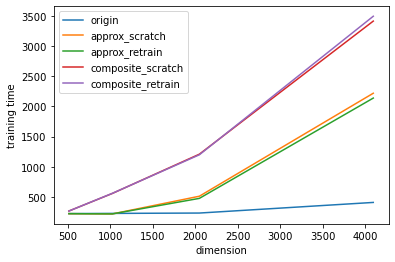

In [34]:
width = [512, 1024, 2048, 4096]
for key in training_time:
    plt.plot(width, training_time[key], label = key)
plt.legend()
plt.xlabel('dimension')
plt.ylabel('training time')
plt.show()

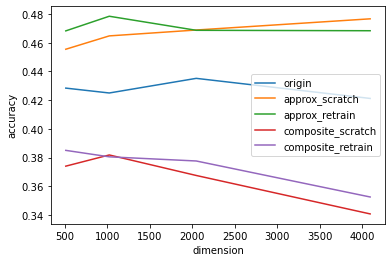

In [35]:
for key in accuracy:
    plt.plot(width, accuracy[key], label = key)
plt.legend()
plt.xlabel('dimension')
plt.ylabel('accuracy')
plt.show()

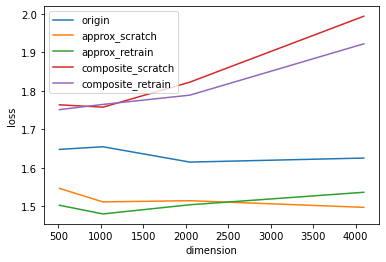

In [36]:
for key in test_loss:
    plt.plot(width, test_loss[key], label = key)
plt.legend()
plt.xlabel('dimension')
plt.ylabel('loss')
plt.show()

### Change depth

In [37]:
"""
Fix width = 1024
"""
hidden_depth = [3,4,5,6]
width = 1024

training_time_2 = {'origin':[], 'approx_scratch':[], 'approx_retrain': [], 'composite_scratch': [], 'composite_retrain': []}
accuracy_2 = {'origin':[], 'approx_scratch':[], 'approx_retrain': [], 'composite_scratch': [], 'composite_retrain': []}
test_loss_2 = {'origin':[], 'approx_scratch':[], 'approx_retrain': [], 'composite_scratch': [], 'composite_retrain': []}

for depth in hidden_depth:
    model_2 = ArcsinNN(in_features=32*32*3, out_features=10, hidden_features=[width]*depth).to(device)
    approx_scratch_2 = ApproxArcsineNN(model_2, indicator=sigmoid_indicator).to(device)
    composite_scratch_2 = RepresentArcsineNN(model_2, indicator=sigmoid_indicator).to(device)

    # train model
    print("training original model")
    optimizer = torch.optim.Adam(params=model_2.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model_2, loss_fn, optimizer)
    end = time()
    training_time_2['origin'].append(end - start)
    acc, loss = test_loop(test_loader, model_2, loss_fn)
    accuracy_2['origin'].append(acc)
    test_loss_2['origin'].append(loss)

    # train approx_scractch
    print("training approx_scratch model")
    optimizer = torch.optim.Adam(params=approx_scratch_2.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_scratch_2, loss_fn, optimizer)
    end = time()
    training_time_2['approx_scratch'].append(end - start)
    acc, loss = test_loop(test_loader, approx_scratch_2, loss_fn)
    accuracy_2['approx_scratch'].append(acc)
    test_loss_2['approx_scratch'].append(loss)

    # train composite_scratch
    print("training composite_scratch model")
    optimizer = torch.optim.Adam(params=composite_scratch_2.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, composite_scratch_2, loss_fn, optimizer)
    end = time()
    training_time_2['composite_scratch'].append(end - start)
    acc, loss = test_loop(test_loader, composite_scratch_2, loss_fn)
    accuracy_2['composite_scratch'].append(acc)
    test_loss_2['composite_scratch'].append(loss)

    approx_retrain_2 = ApproxArcsineNN(model_2).to(device)
    composite_retrain_2 = RepresentArcsineNN(model_2).to(device)

    # train approx_retrain
    print("training approx_retrain model")
    optimizer = torch.optim.Adam(params=approx_retrain_2.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_retrain_2, loss_fn, optimizer)
    end = time()
    training_time_2['approx_retrain'].append(end - start)
    acc, loss = test_loop(test_loader, approx_retrain_2, loss_fn)
    accuracy_2['approx_retrain'].append(acc)
    test_loss_2['approx_retrain'].append(loss)

    # train composite_retrain
    print("training composite_retrain model")
    optimizer = torch.optim.Adam(params=composite_retrain_2.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, composite_retrain_2, loss_fn, optimizer)
    end = time()
    training_time_2['composite_retrain'].append(end - start)
    acc, loss = test_loop(test_loader, composite_retrain_2, loss_fn)
    accuracy_2['composite_retrain'].append(acc)
    test_loss_2['composite_retrain'].append(loss)

training original model
Epoch 1
-------------------------------
loss: 2.307161  [    0/50000]
loss: 2.295392  [ 6400/50000]
loss: 1.959480  [12800/50000]
loss: 2.161211  [19200/50000]
loss: 2.179468  [25600/50000]
loss: 1.985139  [32000/50000]
loss: 1.994977  [38400/50000]
loss: 1.865034  [44800/50000]
Epoch 2
-------------------------------
loss: 1.874931  [    0/50000]
loss: 1.886030  [ 6400/50000]
loss: 1.711579  [12800/50000]
loss: 1.895175  [19200/50000]
loss: 1.940048  [25600/50000]
loss: 1.870014  [32000/50000]
loss: 1.913364  [38400/50000]
loss: 1.772002  [44800/50000]
Epoch 3
-------------------------------
loss: 1.811075  [    0/50000]
loss: 1.823065  [ 6400/50000]
loss: 1.598594  [12800/50000]
loss: 1.845531  [19200/50000]
loss: 1.866423  [25600/50000]
loss: 1.890299  [32000/50000]
loss: 1.865112  [38400/50000]
loss: 1.693425  [44800/50000]
Epoch 4
-------------------------------
loss: 1.805640  [    0/50000]
loss: 1.789563  [ 6400/50000]
loss: 1.545602  [12800/50000]
loss: 

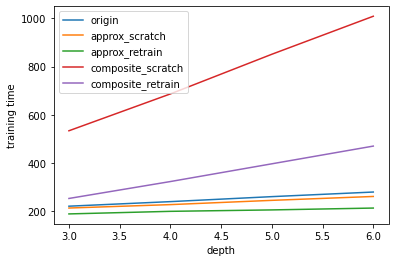

In [38]:
for key in training_time_2:
    plt.plot(hidden_depth, training_time_2[key], label = key)
plt.legend()
plt.xlabel('depth')
plt.ylabel('training time')
plt.show()

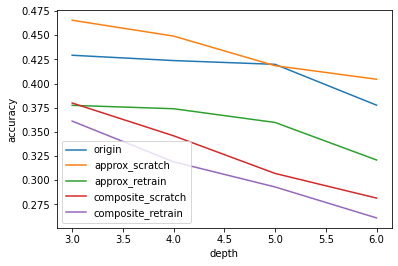

In [39]:
for key in accuracy_2:
    plt.plot(hidden_depth, accuracy_2[key], label = key)
plt.legend()
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.show()

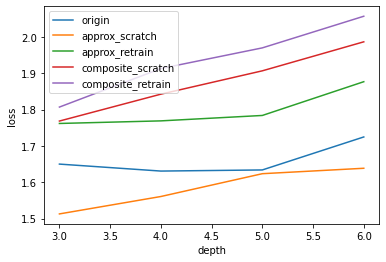

In [40]:
for key in test_loss_2:
    plt.plot(hidden_depth, test_loss_2[key], label = key)
plt.legend()
plt.xlabel('depth')
plt.ylabel('loss')
plt.show()

In [42]:
"""
Training loss over time
"""
depth = 5
width = 1024

model_3 = ArcsinNN(in_features=28*28, out_features=10, hidden_features=[width]*depth).to(device)
approx_scratch_3 = ApproxArcsineNN(model_3).to(device)
composite_scratch_3 = RepresentArcsineNN(model_3).to(device)

training_loss = {'origin':[], 'approx_scratch':[], 'approx_retrain': [], 'composite_scratch': [], 'composite_retrain': []}

# train model
print("training original model")
optimizer = torch.optim.Adam(params=model_3.parameters(),lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_loss['origin'] += train_loop(train_loader, model_3, loss_fn, optimizer)

print("training approx_scratch model")
optimizer = torch.optim.Adam(params=approx_scratch_3.parameters(),lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_loss['approx_scratch'] += train_loop(train_loader, approx_scratch_3, loss_fn, optimizer)

print("training composite_scratch model")
optimizer = torch.optim.Adam(params=composite_scratch_3.parameters(),lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_loss['composite_scratch'] += train_loop(train_loader, composite_scratch_3, loss_fn, optimizer)

approx_retrain_3 = ApproxArcsineNN(model_3).to(device)
composite_retrain_3 = RepresentArcsineNN(model_3).to(device)

print("training approx_retrain model")
optimizer = torch.optim.Adam(params=approx_retrain_3.parameters(),lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_loss['approx_retrain'] += train_loop(train_loader, approx_retrain_3, loss_fn, optimizer)

print("training composite_retrain model")
optimizer = torch.optim.Adam(params=composite_retrain_3.parameters(),lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training_loss['composite_retrain'] +=  train_loop(train_loader, composite_retrain_3, loss_fn, optimizer)


training original model
Epoch 1
-------------------------------
loss: 2.303284  [    0/60000]
loss: 0.796624  [ 6400/60000]
loss: 0.516803  [12800/60000]
loss: 0.839117  [19200/60000]
loss: 0.645899  [25600/60000]
loss: 0.556334  [32000/60000]
loss: 0.593760  [38400/60000]
loss: 0.636858  [44800/60000]
loss: 0.572569  [51200/60000]
loss: 0.622607  [57600/60000]
Epoch 2
-------------------------------
loss: 0.502766  [    0/60000]
loss: 0.560027  [ 6400/60000]
loss: 0.380391  [12800/60000]
loss: 0.673890  [19200/60000]
loss: 0.657071  [25600/60000]
loss: 0.526992  [32000/60000]
loss: 0.520077  [38400/60000]
loss: 0.585495  [44800/60000]
loss: 0.564500  [51200/60000]
loss: 0.572184  [57600/60000]
Epoch 3
-------------------------------
loss: 0.472443  [    0/60000]
loss: 0.534871  [ 6400/60000]
loss: 0.345406  [12800/60000]
loss: 0.635742  [19200/60000]
loss: 0.632434  [25600/60000]
loss: 0.459517  [32000/60000]
loss: 0.500651  [38400/60000]
loss: 0.567645  [44800/60000]
loss: 0.543434  

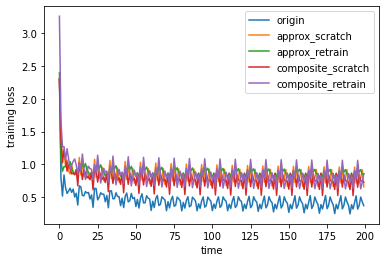

In [43]:
for key in test_loss_2:
    plt.plot(np.arange(len(training_loss[key])), training_loss[key], label = key)
plt.legend()
plt.xlabel('time')
plt.ylabel('training loss')
plt.show()

### Different surrogates of indicator

In [8]:
"""
Experiments with different "indicator" functions:
"""
depth = 3
width = 1024

training_time_4 = {'origin':{}, 'approx_scratch':{}, 'approx_retrain': {}, 'composite_scratch': {}, 'composite_retrain': {}}
accuracy_4 = {'origin':{}, 'approx_scratch':{}, 'approx_retrain': {}, 'composite_scratch': {}, 'composite_retrain': {}}
test_loss_4 = {'origin':{}, 'approx_scratch':{}, 'approx_retrain': {}, 'composite_scratch': {}, 'composite_retrain': {}}


for indicator, name in zip(indicators, indicator_names):
    model_4 = ArcsinNN(in_features=28*28, out_features=10, hidden_features=[width]*depth).to(device)
    approx_scratch_4 = ApproxArcsineNN(model_4, indicator = indicator).to(device)
    composite_scratch_4 = RepresentArcsineNN(model_4, indicator = indicator).to(device)

    # train model
    print("training original model")
    optimizer = torch.optim.Adam(params=model_4.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model_4, loss_fn, optimizer)
    end = time()
    training_time_4['origin'][name] = end - start
    acc, loss = test_loop(test_loader, model_4, loss_fn)
    accuracy_4['origin'][name] = acc
    test_loss_4['origin'][name] = loss

    # train approx_scractch
    print("training approx_scratch model")
    optimizer = torch.optim.Adam(params=approx_scratch_4.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_scratch_4, loss_fn, optimizer)
    end = time()
    training_time_4['approx_scratch'][name] = end - start
    acc, loss = test_loop(test_loader, approx_scratch_4, loss_fn)
    accuracy_4['approx_scratch'][name] = acc
    test_loss_4['approx_scratch'][name] = loss

    # train composite_scratch
    print("training composite_scratch model")
    optimizer = torch.optim.Adam(params=composite_scratch_4.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, composite_scratch_4, loss_fn, optimizer)
    end = time()
    training_time_4['composite_scratch'][name] = end - start
    acc, loss = test_loop(test_loader, composite_scratch_4, loss_fn)
    accuracy_4['composite_scratch'][name] = acc
    test_loss_4['composite_scratch'][name] = loss

    approx_retrain_4 = ApproxArcsineNN(model_4, indicator=indicator).to(device)
    composite_retrain_4 = RepresentArcsineNN(model_4, indicator=indicator).to(device)

    # train approx_retrain
    print("training approx_retrain model")
    optimizer = torch.optim.Adam(params=approx_retrain_4.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_retrain_4, loss_fn, optimizer)
    end = time()
    training_time_4['approx_retrain'][name] = end - start
    acc, loss = test_loop(test_loader, approx_retrain_4, loss_fn)
    accuracy_4['approx_retrain'][name] = acc
    test_loss_4['approx_retrain'][name] = loss

    # train composite_retrain
    print("training composite_retrain model")
    optimizer = torch.optim.Adam(params=composite_retrain_4.parameters(),lr=learning_rate)
    start = time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, composite_retrain_4, loss_fn, optimizer)
    end = time()
    training_time_4['composite_retrain'][name] = end - start
    acc, loss = test_loop(test_loader, composite_retrain_4, loss_fn)
    accuracy_4['composite_retrain'][name] = acc
    test_loss_4['composite_retrain'][name] = loss

training original model
Epoch 1
-------------------------------
loss: 2.303852  [    0/60000]
loss: 0.642915  [ 6400/60000]
loss: 0.476984  [12800/60000]
loss: 0.635661  [19200/60000]
loss: 0.640381  [25600/60000]
loss: 0.469376  [32000/60000]
loss: 0.521839  [38400/60000]
loss: 0.605960  [44800/60000]
loss: 0.478227  [51200/60000]
loss: 0.484529  [57600/60000]
Epoch 2
-------------------------------
loss: 0.413030  [    0/60000]
loss: 0.492595  [ 6400/60000]
loss: 0.359513  [12800/60000]
loss: 0.511520  [19200/60000]
loss: 0.554218  [25600/60000]
loss: 0.448369  [32000/60000]
loss: 0.410034  [38400/60000]
loss: 0.562468  [44800/60000]
loss: 0.493670  [51200/60000]
loss: 0.484261  [57600/60000]
Epoch 3
-------------------------------
loss: 0.379221  [    0/60000]
loss: 0.462444  [ 6400/60000]
loss: 0.329886  [12800/60000]
loss: 0.451922  [19200/60000]
loss: 0.505356  [25600/60000]
loss: 0.412332  [32000/60000]
loss: 0.376808  [38400/60000]
loss: 0.545094  [44800/60000]
loss: 0.482938  

In [26]:
formulations = ["", "origin", "approx_scratch", "approx_retrain", "composite_scratch", "composite_retrain"]
print(*[f"{form:<15}" for form in formulations])
for function_name in indicator_names:
    print(*([f"{function_name:<15}"] + [f"{accuracy_4[form][function_name]:<15}" for form in formulations[1:]]))

                origin          approx_scratch  approx_retrain  composite_scratch composite_retrain
indicator       0.8461          0.777           0.713           0.7739          0.77           
tanh            0.8468          0.8456          0.8387          0.7799          0.7917         
arctan          0.8475          0.8596          0.8485          0.7813          0.7855         
sigmoid(x)      0.8468          0.866           0.8542          0.7972          0.8059         
sigmoid(10x)    0.8464          0.8059          0.7824          0.7729          0.7791         
sigmoid(20x)    0.8472          0.7828          0.7741          0.7462          0.7705         


In [29]:
print(*[f"{form:<20}" for form in formulations])
for function_name in indicator_names:
    print(*([f"{function_name:<20}"] + [f"{training_time_4[form][function_name]:<20}" for form in formulations[1:]]))

                     origin               approx_scratch       approx_retrain       composite_scratch    composite_retrain   
indicator            237.62925720214844   186.17099523544312   187.89342713356018   190.4092938899994    189.78435707092285  
tanh                 226.88217973709106   220.67263007164001   225.5507833957672    230.30336666107178   228.72099924087524  
arctan               225.7462239265442    225.48899126052856   232.63449335098267   239.67533040046692   231.26123809814453  
sigmoid(x)           229.90001344680786   213.08271026611328   212.88853478431702   220.33030128479004   220.33730697631836  
sigmoid(10x)         229.49462294578552   222.33182311058044   218.75786972045898   226.07218718528748   225.73723077774048  
sigmoid(20x)         228.60233402252197   216.95122933387756   217.7669711112976    223.83448481559753   223.9325749874115   


### Increase feature map projection dimension

In [8]:
"""
Fix depth = 2
Change project dimension
"""
hidden_depth = 2
width = 1024
project_dims = [768, 1024, 2048, 4096, 7680, 10000]

res_time_2 = []
res_acc_2 = []
res_loss_2 = []
for i in range(1):
    training_time = {'origin':[], 'approx_no_factoring_scratch':[], 'approx_no_factoring_retrain': [], 'approx_factoring_scratch': [], 'approx_factoring_retrain': []}
    accuracy = {'origin':[], 'approx_no_factoring_scratch':[], 'approx_no_factoring_retrain': [], 'approx_factoring_scratch': [], 'approx_factoring_retrain': []}
    test_loss = {'origin':[], 'approx_no_factoring_scratch':[], 'approx_no_factoring_retrain': [], 'approx_factoring_scratch': [], 'approx_factoring_retrain': []}
    for project_dim in project_dims:
        model = ArcsinNN(in_features=784, out_features=10, hidden_features=[width]*hidden_depth, bias=False).to(device)
        approx_no_factoring_scratch = ApproxArcsineNN(model,indicator=sigmoid_indicator, seed=20220904, project_dim=project_dim).to(device)
        approx_factoring_scratch = RepresentArcsineNN(model, indicator=sigmoid_indicator, seed=20220904, project_dim=project_dim).to(device)
        # train model
        print("training original model")
        optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)
        start = time()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, model, loss_fn, optimizer)
        end = time()
        training_time['origin'].append(end - start)
        acc, loss = test_loop(test_loader, model, loss_fn)
        accuracy['origin'].append(acc)
        test_loss['origin'].append(loss)

        # train approx_scractch
        print("training approx_no_factoring_scratch model")
        optimizer = torch.optim.Adam(params=approx_no_factoring_scratch.parameters(),lr=learning_rate)
        start = time()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, approx_no_factoring_scratch, loss_fn, optimizer)
        end = time()
        training_time['approx_no_factoring_scratch'].append(end - start)
        acc, loss = test_loop(test_loader, approx_no_factoring_scratch, loss_fn)
        accuracy['approx_no_factoring_scratch'].append(acc)
        test_loss['approx_no_factoring_scratch'].append(loss)

        # train approx_factoring_scratch
        print("training approx_factoring_scratch model")
        optimizer = torch.optim.Adam(params=approx_factoring_scratch.parameters(),lr=learning_rate)
        start = time()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, approx_factoring_scratch, loss_fn, optimizer)
        end = time()
        training_time['approx_factoring_scratch'].append(end - start)
        acc, loss = test_loop(test_loader, approx_factoring_scratch, loss_fn)
        accuracy['approx_factoring_scratch'].append(acc)
        test_loss['approx_factoring_scratch'].append(loss)

        approx_no_factoring_retrain = ApproxArcsineNN(model,indicator=sigmoid_indicator, seed=20220904, project_dim=project_dim).to(device)
        approx_factoring_retrain = RepresentArcsineNN(model,indicator=sigmoid_indicator, seed=20220904, project_dim=project_dim).to(device)

        # train approx_no_factoring_retrain
        print("training approx_factoring_scratch model")
        optimizer = torch.optim.Adam(params=approx_no_factoring_retrain.parameters(),lr=learning_rate)
        start = time()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, approx_no_factoring_retrain, loss_fn, optimizer)
        end = time()
        training_time['approx_no_factoring_retrain'].append(end - start)
        acc, loss = test_loop(test_loader, approx_no_factoring_retrain, loss_fn)
        accuracy['approx_no_factoring_retrain'].append(acc)
        test_loss['approx_no_factoring_retrain'].append(loss)

        # train approx_factoring_retrain
        print("training approx_factoring_retrain model")
        optimizer = torch.optim.Adam(params=approx_factoring_retrain.parameters(),lr=learning_rate)
        start = time()
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, approx_factoring_retrain, loss_fn, optimizer)
        end = time()
        training_time['approx_factoring_retrain'].append(end - start)
        acc, loss = test_loop(test_loader, approx_factoring_retrain, loss_fn)
        accuracy['approx_factoring_retrain'].append(acc)
        test_loss['approx_factoring_retrain'].append(loss)
    res_time_2.append(training_time) 
    res_loss_2.append(test_loss)
    res_acc_2.append(accuracy)

training original model
Epoch 1
-------------------------------
loss: 2.298016  [    0/60000]
loss: 0.565429  [ 6400/60000]
loss: 0.460210  [12800/60000]
loss: 0.615854  [19200/60000]
loss: 0.518545  [25600/60000]
loss: 0.469487  [32000/60000]
loss: 0.445154  [38400/60000]
loss: 0.572818  [44800/60000]
loss: 0.521270  [51200/60000]
loss: 0.472605  [57600/60000]
Epoch 2
-------------------------------
loss: 0.440913  [    0/60000]
loss: 0.420582  [ 6400/60000]
loss: 0.365501  [12800/60000]
loss: 0.525951  [19200/60000]
loss: 0.552843  [25600/60000]
loss: 0.417677  [32000/60000]
loss: 0.414868  [38400/60000]
loss: 0.545167  [44800/60000]
loss: 0.505956  [51200/60000]
loss: 0.415567  [57600/60000]
Epoch 3
-------------------------------
loss: 0.405489  [    0/60000]
loss: 0.416041  [ 6400/60000]
loss: 0.334544  [12800/60000]
loss: 0.523355  [19200/60000]
loss: 0.530776  [25600/60000]
loss: 0.423693  [32000/60000]
loss: 0.403789  [38400/60000]
loss: 0.547730  [44800/60000]
loss: 0.476135  

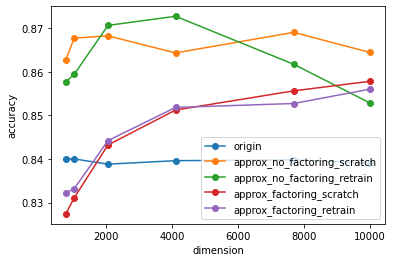

In [10]:
res_acc_avg_2 = {key: np.mean(np.array([res_acc_2[i][key] for i in range(1)]),axis=0) for key in accuracy}
res_acc_avg_2
for key in res_acc_avg_2:
    plt.plot(project_dims, res_acc_avg_2[key], '-o')
plt.legend(res_acc_avg_2.keys())
plt.xlabel('dimension')
plt.ylabel('accuracy')
plt.show()

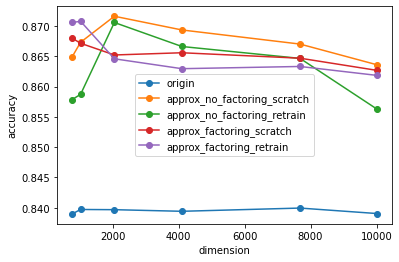

In [14]:
res_acc_avg_2 = {key: np.mean(np.array([res_acc_2[i][key] for i in range(3)]),axis=0) for key in accuracy}
res_acc_avg_2
for key in res_acc_avg_2:
    plt.plot(project_dims, res_acc_avg_2[key], '-o')
plt.legend(res_acc_avg_2.keys())
plt.xlabel('dimension')
plt.ylabel('accuracy')
plt.show()

{'origin': array([205.78090199, 206.28338472, 204.75115681, 209.44032494,
       209.98645155, 201.47357194]), 'approx_no_factoring_scratch': array([206.15622536, 206.30678376, 208.78434753, 210.96124967,
       294.55665827, 354.3845884 ]), 'approx_no_factoring_retrain': array([205.78379377, 206.21282625, 210.40437516, 211.11180345,
       286.47341506, 373.37651666]), 'approx_factoring_scratch': array([211.79855386, 212.53539046, 216.42035158, 216.31489913,
       218.18390131, 253.96133582]), 'approx_factoring_retrain': array([211.74077805, 210.71239607, 216.48129606, 216.98088606,
       212.70890816, 260.58924898])}


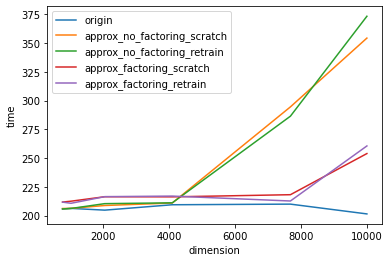

In [10]:
res_time_avg_2 = {key: np.mean(np.array([res_time_2[i][key] for i in range(3)]),axis=0) for key in accuracy}
print(res_time_avg_2)
for key in res_time_avg_2:
    plt.plot(project_dims, res_time_avg_2[key])
plt.legend(res_time_avg_2.keys())
plt.xlabel('dimension')
plt.ylabel('time')
plt.show()

### Training dynamics of "kernel" matrix

In [8]:
"""
Fix depth = 2
Change project dimension
"""
hidden_depth = 2
width = 1024
project_dims = [1024, 10000]

svdvals_scratch = {d:[] for d in project_dims}
svdvals_retrain = {d:[] for d in project_dims}    
for d in project_dims:
    model = ArcsinNN(in_features=784, out_features=10, hidden_features=[width]*hidden_depth, bias=False).to(device)
    approx_factoring_scratch = RepresentArcsineNN(model, indicator=sigmoid_indicator, seed=20220904, project_dim=d).to(device)
    
    # train model
    print("training original model")
    optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model, loss_fn, optimizer)

    # train approx_factoring_scratch
    print("training approx_factoring_scratch model")
    optimizer = torch.optim.Adam(params=approx_factoring_scratch.parameters(),lr=learning_rate)
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_factoring_scratch, loss_fn, optimizer)
        
        W = torch.eye(approx_factoring_scratch.Linears[0].weight.shape[1], device=approx_factoring_scratch.Linears[0].weight.device)
        for i in range(approx_factoring_scratch.num_hidden_layers):
            # compute phi(phi(...phi(W)))
            W = torch.matmul(approx_factoring_scratch.Linears[i].weight.clone().detach(), W)
            W = approx_factoring_scratch.RandomFeatureMaps[W.shape[1]](W)
            W = (torch.pi/2/W.shape[1]) * W
        # W = torch.matmul(approx_factoring_scratch.Output.weight.clone().detach(), W)
        svdvals_scratch[d].append(torch.linalg.svdvals(W))

    approx_factoring_retrain = RepresentArcsineNN(model,indicator=sigmoid_indicator, seed=20220904, project_dim=d).to(device)

    # train approx_factoring_retrain
    print("training approx_factoring_retrain model")
    optimizer = torch.optim.Adam(params=approx_factoring_retrain.parameters(),lr=learning_rate)
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, approx_factoring_retrain, loss_fn, optimizer)

        W = torch.eye(approx_factoring_retrain.Linears[0].weight.shape[1], device=approx_factoring_retrain.Linears[0].weight.device)
        for i in range(approx_factoring_retrain.num_hidden_layers):
            # compute phi(phi(...phi(W)))
            W = torch.matmul(approx_factoring_retrain.Linears[i].weight.clone().detach(), W)
            W = approx_factoring_retrain.RandomFeatureMaps[W.shape[1]](W)
            W = (torch.pi/2/W.shape[1]) * W
        # W = torch.matmul(approx_factoring_retrain.Output.weight.clone().detach(), W)
        svdvals_retrain[d].append(torch.linalg.svdvals(W))

training original model
Epoch 1
-------------------------------
loss: 2.298706  [    0/60000]
loss: 0.566522  [ 6400/60000]
loss: 0.450893  [12800/60000]
loss: 0.611297  [19200/60000]
loss: 0.541446  [25600/60000]
loss: 0.468145  [32000/60000]
loss: 0.444810  [38400/60000]
loss: 0.545328  [44800/60000]
loss: 0.522565  [51200/60000]
loss: 0.475854  [57600/60000]
Epoch 2
-------------------------------
loss: 0.437579  [    0/60000]
loss: 0.417668  [ 6400/60000]
loss: 0.366836  [12800/60000]
loss: 0.521375  [19200/60000]
loss: 0.564484  [25600/60000]
loss: 0.419803  [32000/60000]
loss: 0.409526  [38400/60000]
loss: 0.539459  [44800/60000]
loss: 0.506504  [51200/60000]
loss: 0.419591  [57600/60000]
Epoch 3
-------------------------------
loss: 0.401636  [    0/60000]
loss: 0.416392  [ 6400/60000]
loss: 0.334849  [12800/60000]
loss: 0.521721  [19200/60000]
loss: 0.536731  [25600/60000]
loss: 0.424176  [32000/60000]
loss: 0.399580  [38400/60000]
loss: 0.544685  [44800/60000]
loss: 0.479566  

In [9]:
svdvals_dict = {
    "scratch_start_1024": svdvals_scratch[1024][0],
    "scratch_end_1024": svdvals_scratch[1024][-1],
    "scratch_start_10000": svdvals_scratch[10000][0],
    "scratch_end_10000": svdvals_scratch[10000][-1],
    "retrain_start_1024": svdvals_retrain[1024][0],
    "retrain_end_1024": svdvals_retrain[1024][-1],
    "retrain_start_10000": svdvals_retrain[10000][0],
    "retrain_end_10000": svdvals_retrain[10000][-1],
}

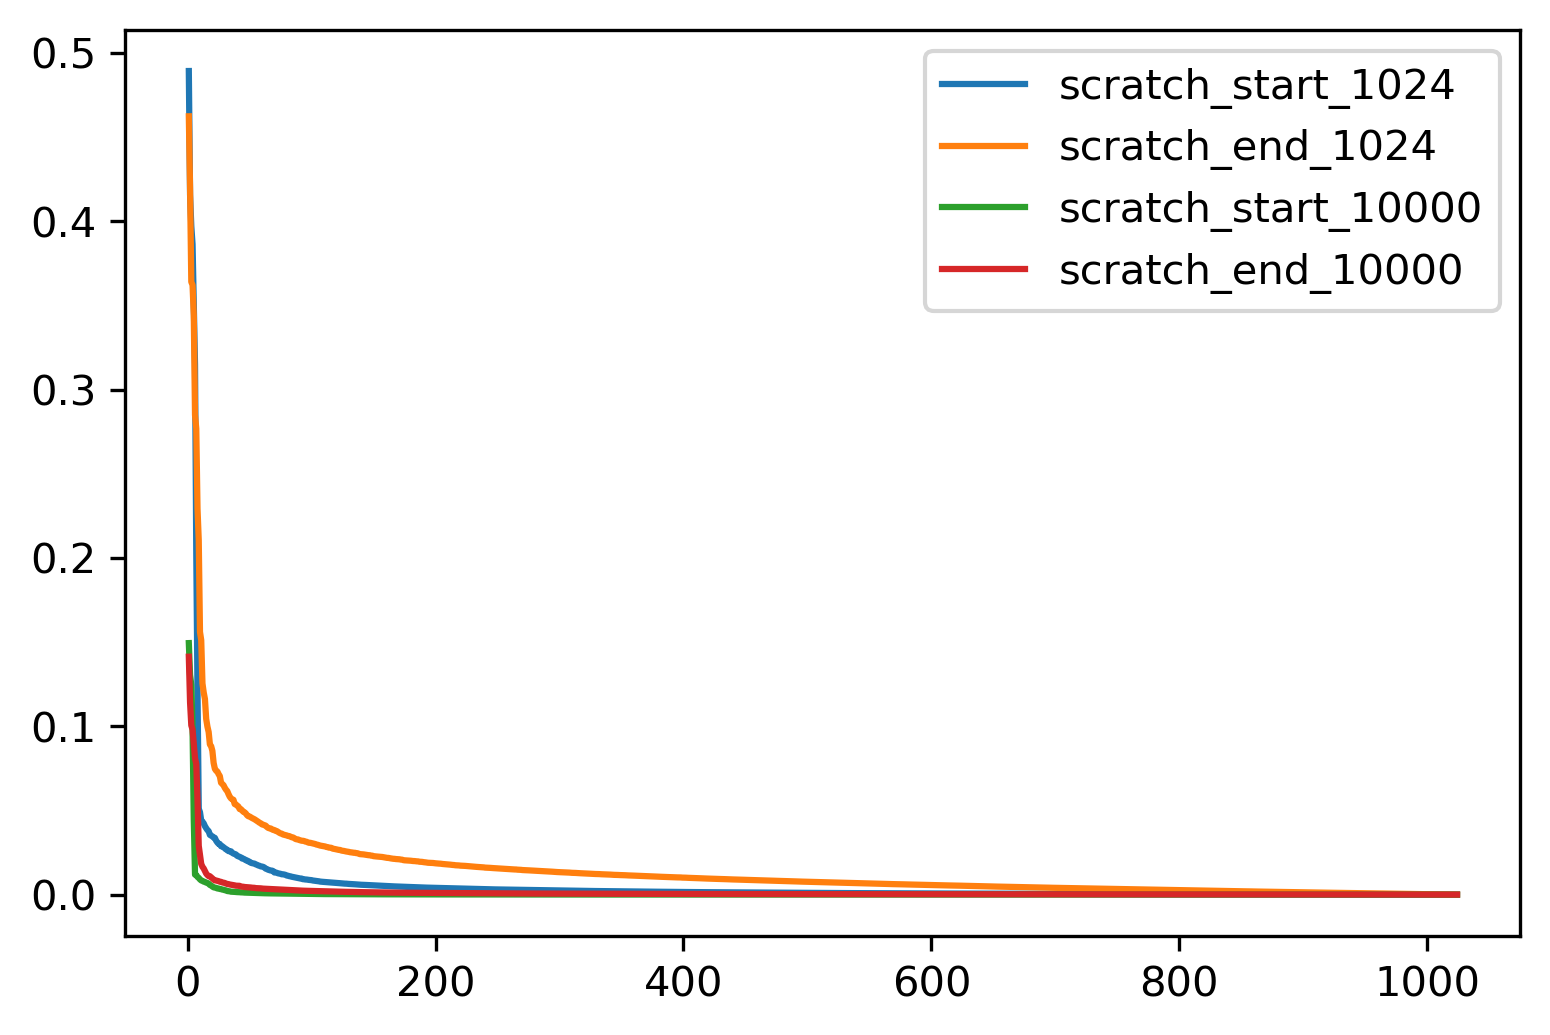

In [24]:
index = np.arange(1,1025)
keys = ["scratch_start_1024", "scratch_end_1024", "scratch_start_10000", "scratch_end_10000"]
for x in keys:
    plt.plot(index, svdvals_dict[x].cpu())
plt.legend(keys)

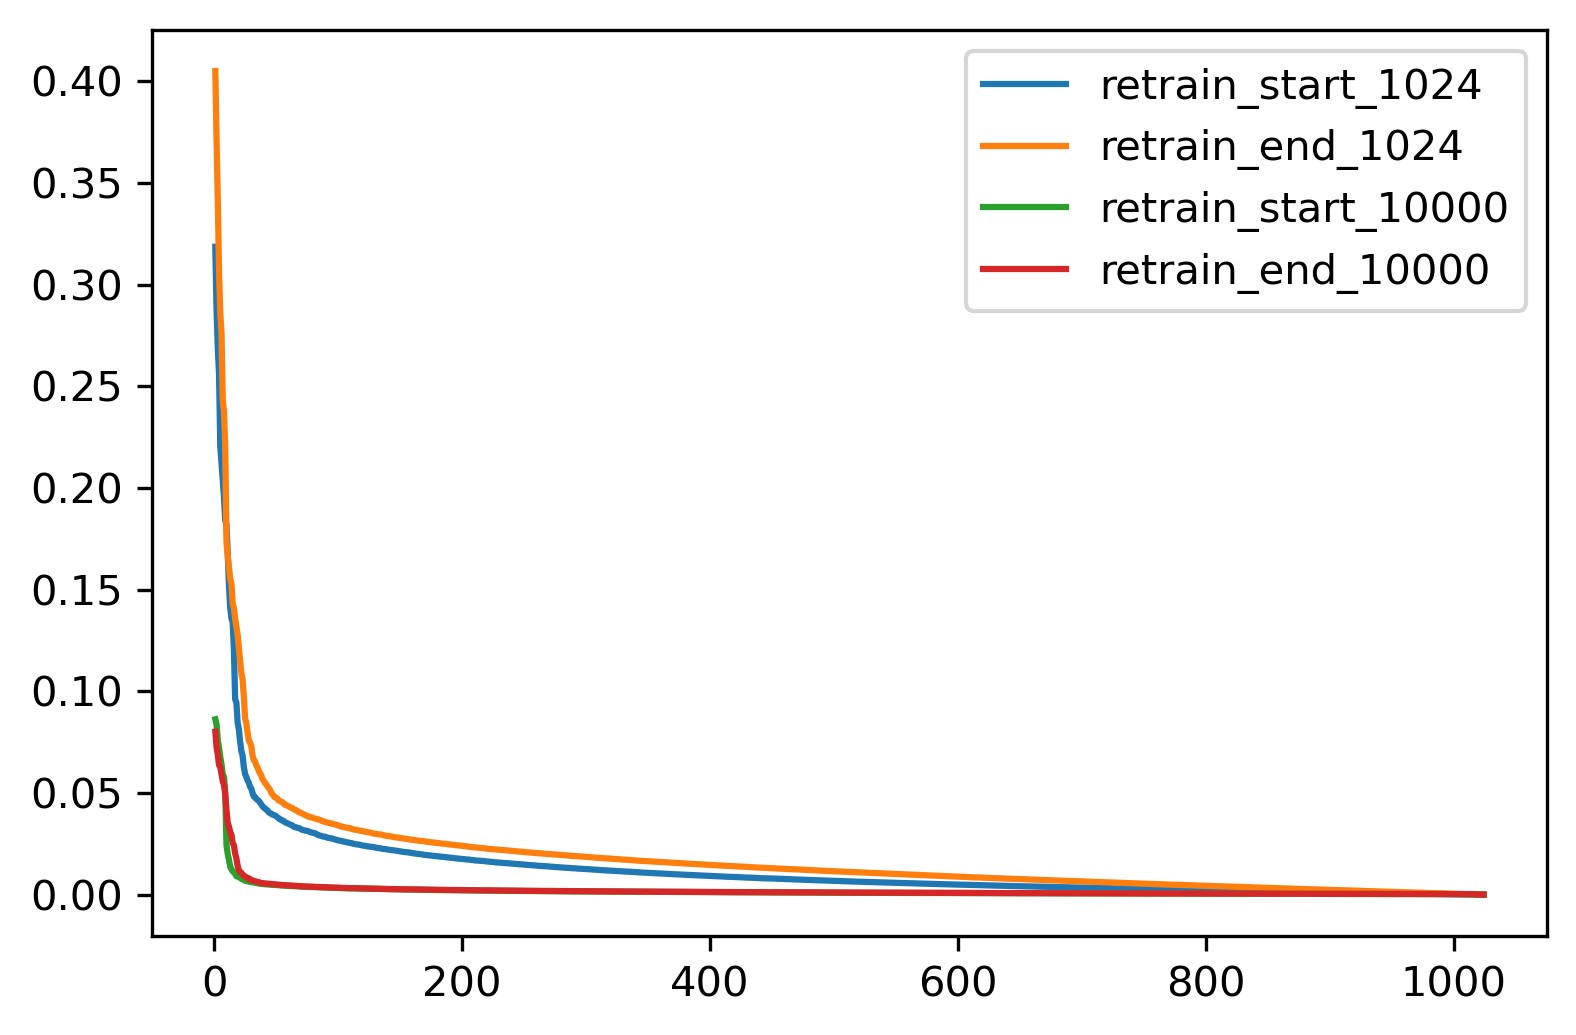

In [25]:
index = np.arange(1,1025)
keys = ["retrain_start_1024", "retrain_end_1024", "retrain_start_10000", "retrain_end_10000"]
for x in keys:
    plt.plot(index, svdvals_dict[x].cpu())
plt.legend(keys)

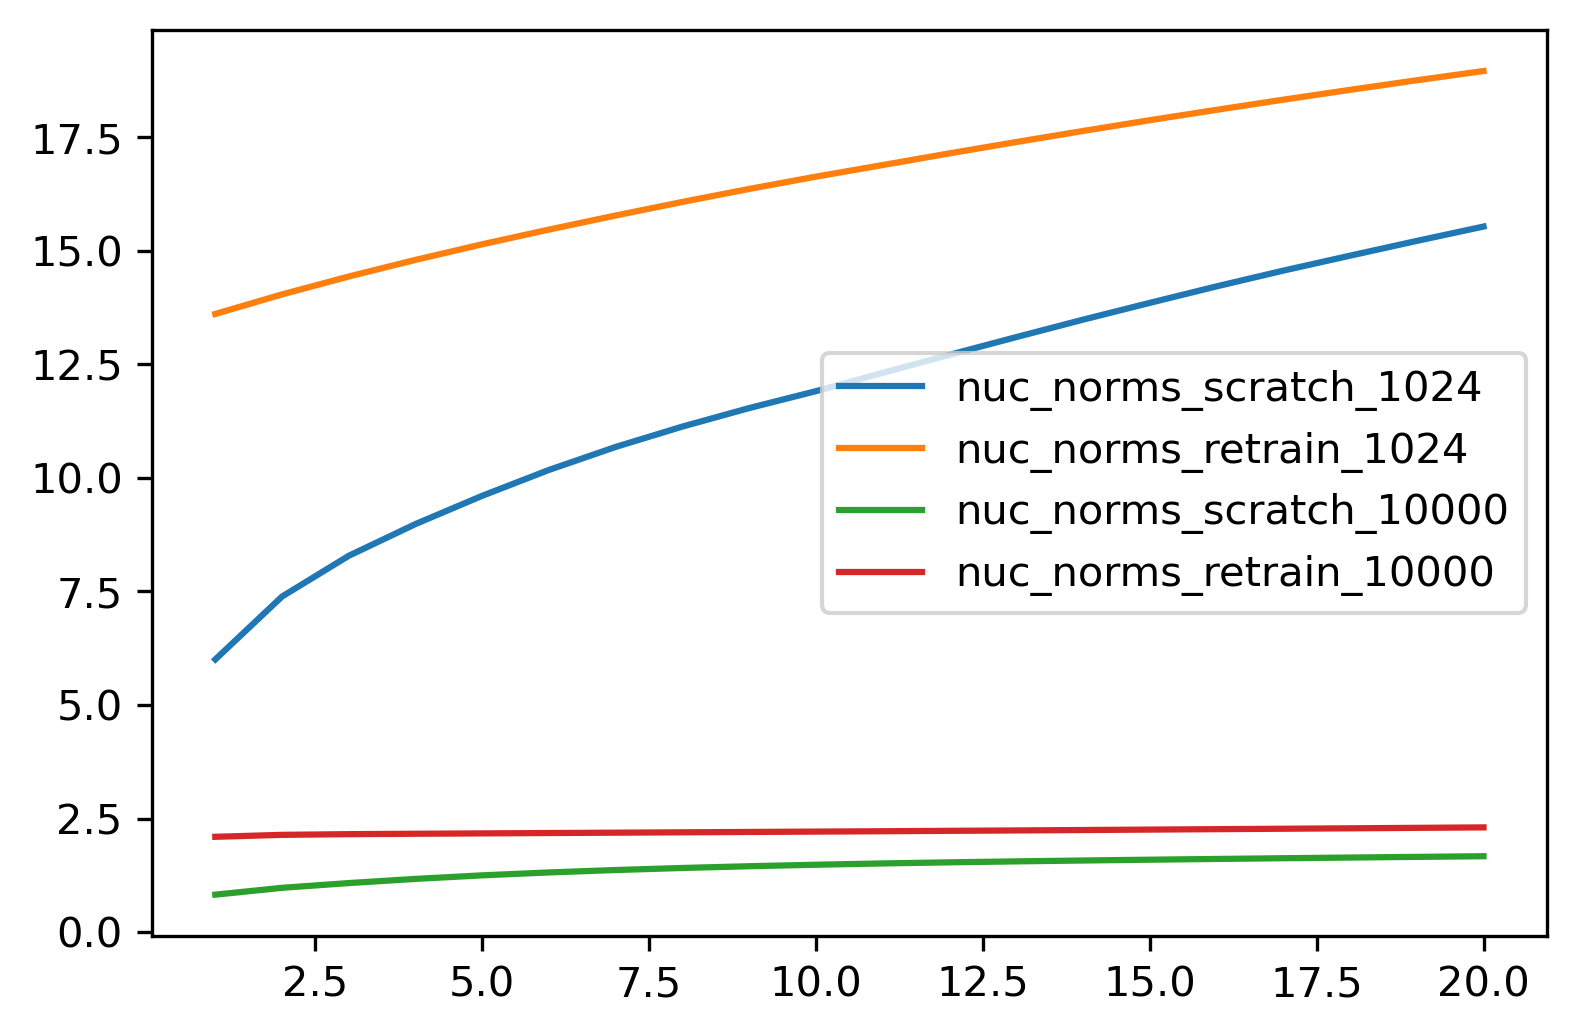

In [26]:
nuc_norms_scratch = {d: [torch.sum(x).cpu() for x in svdvals_scratch[d]] for d in project_dims}
nuc_norms_retrain = {d: [torch.sum(x).cpu() for x in svdvals_retrain[d]] for d in project_dims}
for d in project_dims:
    plt.plot(np.arange(1,21), nuc_norms_scratch[d])
    plt.plot(np.arange(1,21), nuc_norms_retrain[d])
plt.legend(["nuc_norms_scratch_1024", "nuc_norms_retrain_1024", "nuc_norms_scratch_10000", "nuc_norms_retrain_10000"])

In [ ]:
nuc_norms_scratch = {d: [torch.sum(x).cpu() for x in svdvals_scratch[d]] for d in project_dims}
nuc_norms_retrain = {d: [torch.sum(x).cpu() for x in svdvals_retrain[d]] for d in project_dims}
for d in project_dims:
    plt.plot(np.arange(1,21), nuc_norms_scratch[d])
    plt.plot(np.arange(1,21), nuc_norms_retrain[d])
plt.legend(["nuc_norms_scratch_1024", "nuc_norms_retrain_1024", "nuc_norms_scratch_10000", "nuc_norms_retrain_10000"])

In [31]:
for i, x in enumerate(svdvals_dict["scratch_start_1024"]):
    if x/torch.sum(svdvals_dict["scratch_start_1024"]) < 1e-3:
        print(i)
        break
for i, x in enumerate(svdvals_dict["scratch_end_1024"]):
    if x/torch.sum(svdvals_dict["scratch_end_1024"]) < 1e-3:
        print(i)
        break

138
250


In [32]:
for i, x in enumerate(svdvals_dict["scratch_start_10000"]):
    if x/torch.sum(svdvals_dict["scratch_start_10000"]) < 1e-3:
        print(i)
        break
for i, x in enumerate(svdvals_dict["scratch_end_10000"]):
    if x/torch.sum(svdvals_dict["scratch_end_10000"]) < 1e-3:
        print(i)
        break

64
127
